## **County vs. Solar-Containing Block Group Distribution Checks**
### Technoeconomic + Social Factors

This notebook performs a distribution sanity-check by comparing County-level values against Block Groups that contain at least one solar project (“Solar-BG only”) using KDE plots.

### What is included

**Technoeconomic suitability variables (0–100):**
* GHI
* Protected Land
* Habitat
* Slope
* Population Density
* Distance to Substation
* Land Cover

**Social variables:**
* Income (USD)
* HS education only (% of population, 0–100)
* Graduate/Professional degree only (% of population, 0–100)
* Black and Asian population shares (% of population, 0–100)
* Unemployment rate (%)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [30]:
basepath = basepath  

# Suitability tables
suitability_county = pd.read_csv(basepath + "suitability_scores/suitability_scores_county.csv")
suitability_bg = pd.read_csv(basepath + "suitability_scores/suitability_scores_bg.csv")
project_suitability = pd.read_csv(basepath + "suitability_scores/suitability_scores_project.csv")

# Social factor source tables
bg_income = pd.read_csv(basepath + "block_group_clean/income_bg.csv")
bg_edu    = pd.read_csv(basepath + "block_group_clean/education_bg.csv")
bg_unemp  = pd.read_csv(basepath + "block_group_clean/unemployment_bg.csv")

try:
    bg_race = pd.read_csv(basepath + "block_group_clean/race_percent_bg.csv")
    race_source = "race_percent_bg.csv"
except FileNotFoundError:
    bg_race = pd.read_csv(basepath + "block_group_clean/race_bg.csv")
    race_source = "race_bg.csv"

cty_social = pd.read_csv(basepath + "county_clean/social_factors_merged.csv")

print("Using BG race file:", race_source)
print("Loaded.")

Using BG race file: race_percent_bg.csv
Loaded.


In [31]:
def pad_str(series, width):
    return (
        series.astype(str)
        .str.replace(r"\.0$", "", regex=True)
        .str.strip()
        .str.zfill(width)
    )

def ensure_geoid_bg(df, name):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    # Already has GEOID
    if "GEOID" in df.columns:
        df["GEOID"] = (
            df["GEOID"].astype(str)
            .str.replace(r"\.0$", "", regex=True)
            .str.strip()
            .str.zfill(12)
            .str[:12]
        )
        return df

    def has_cols(cols):
        return all(c in df.columns for c in cols)

    if has_cols(["State", "County", "Tract", "Block"]):
        df["GEOID"] = pad_str(df["State"], 2) + pad_str(df["County"], 3) + pad_str(df["Tract"], 6) + pad_str(df["Block"], 1)
        return df

    if has_cols(["State", "County", "Tract", "Block Group"]):
        df["GEOID"] = pad_str(df["State"], 2) + pad_str(df["County"], 3) + pad_str(df["Tract"], 6) + pad_str(df["Block Group"], 1)
        return df

    if has_cols(["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"]):
        df["GEOID"] = pad_str(df["STATEFP"], 2) + pad_str(df["COUNTYFP"], 3) + pad_str(df["TRACTCE"], 6) + pad_str(df["BLKGRPCE"], 1)
        return df

    raise KeyError(f"[{name}] Could not construct BG GEOID. Columns: {list(df.columns)}")

def ensure_geoid_county(df, name):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    # Already has GEOID
    if "GEOID" in df.columns:
        df["GEOID"] = (
            df["GEOID"].astype(str)
            .str.replace("US", "", regex=False)
            .str.replace(r"\.0$", "", regex=True)
            .str.strip()
            .str.zfill(5)
            .str[:5]
        )
        return df

    # Other county ID columns
    for c in ["FIPS", "fips", "CountyFIPS", "COUNTY_FIPS", "county_fips", "GEOIDFQ"]:
        if c in df.columns:
            df["GEOID"] = (
                df[c].astype(str)
                .str.replace("US", "", regex=False)
                .str.replace(r"\.0$", "", regex=True)
                .str.strip()
                .str.zfill(5)
                .str[:5]
            )
            return df

    # Build from state/county code columns
    state_candidates = ["STATEFP", "statefp", "State", "STATE", "FIPS State"]
    county_candidates = ["COUNTYFP", "countyfp", "County", "COUNTY", "FIPS County"]

    state_col = next((c for c in state_candidates if c in df.columns), None)
    county_col = next((c for c in county_candidates if c in df.columns), None)

    if state_col is not None and county_col is not None:
        df["GEOID"] = pad_str(df[state_col], 2) + pad_str(df[county_col], 3)
        return df

    if "County Name" in df.columns and "State" in df.columns:
        return df

    raise KeyError(f"[{name}] Could not construct county GEOID. Columns: {list(df.columns)}")

In [32]:
# Standardize BG GEOIDs
suitability_bg = ensure_geoid_bg(suitability_bg, "suitability_bg")
project_suitability = ensure_geoid_bg(project_suitability, "project_suitability")
bg_income = ensure_geoid_bg(bg_income, "bg_income")
bg_edu = ensure_geoid_bg(bg_edu, "bg_edu")
bg_race = ensure_geoid_bg(bg_race, "bg_race")
bg_unemp = ensure_geoid_bg(bg_unemp, "bg_unemp")

cty_social = ensure_geoid_county(cty_social, "cty_social")

# Try county suitability GEOID directly; if absent, will map by name/state
suitability_county = ensure_geoid_county(suitability_county, "suitability_county")

print("BG GEOID example:", suitability_bg["GEOID"].head(1).tolist())
print("Project GEOID example:", project_suitability["GEOID"].head(1).tolist())
print("County social GEOID example:", cty_social["GEOID"].head(1).tolist())

BG GEOID example: ['011130303001']
Project GEOID example: ['250092072001']
County social GEOID example: ['01001']


In [33]:
# If suitability_county still lacks GEOID, map from cty_social using county/state names
if "GEOID" not in suitability_county.columns:
    print("suitability_county has no GEOID; attempting County Name + State mapping...")

    # Detect county/state name columns in county social table
    county_name_col = next((c for c in cty_social.columns if c.lower().strip() in ["county name", "county", "name"]), None)
    state_name_col = next((c for c in cty_social.columns if c.lower().strip() in ["state", "state name"]), None)

    if county_name_col is None or state_name_col is None:
        raise KeyError("Could not find county/state name columns in cty_social for mapping.")

    lookup = (
        cty_social[[county_name_col, state_name_col, "GEOID"]]
        .dropna()
        .drop_duplicates()
        .rename(columns={county_name_col: "County Name", state_name_col: "State"})
    )

    # Clean merge keys
    for col in ["County Name", "State"]:
        suitability_county[col] = suitability_county[col].astype(str).str.strip().str.lower()
        lookup[col] = lookup[col].astype(str).str.strip().str.lower()

    suitability_county = suitability_county.merge(
        lookup, on=["County Name", "State"], how="left"
    )

# Report missing GEOID
missing_rate = suitability_county["GEOID"].isna().mean() * 100
print(f"suitability_county GEOID missing rate: {missing_rate:.2f}%")

if missing_rate > 0:
    sample_unmatched = suitability_county.loc[suitability_county["GEOID"].isna(), ["State", "County Name"]].drop_duplicates().head(10)
    print("Sample unmatched county/state pairs:")
    display(sample_unmatched)

suitability_county has no GEOID; attempting County Name + State mapping...
suitability_county GEOID missing rate: 4.10%
Sample unmatched county/state pairs:


,State,County Name
26,nan,nan


In [34]:
# BGs that contain at least one project
solar_bg_geoids = set(project_suitability["GEOID"].dropna().astype(str).unique())
print("Solar BG count:", len(solar_bg_geoids))

# BG technoeconomic restricted to solar-containing BGs
suitability_bg_solar = suitability_bg[suitability_bg["GEOID"].isin(solar_bg_geoids)].copy()
print("suitability_bg_solar rows:", len(suitability_bg_solar))

Solar BG count: 2963
suitability_bg_solar rows: 2963


In [35]:
cty_income_col = "Median Income"
cty_hs_col     = "25+ High school graduate"                 # exact HS-only
cty_grad_col   = "25+ Graduate or professional degree"      # exact grad-only
cty_black_col  = "Black/African American"
cty_asian_col  = "Asian"
cty_unemp_col  = "Unemployment Rate"

bg_income_col = "Median Household Income"
bg_hs_col     = "high_school_graduate"       # HS-only
bg_grad_col   = "graduate_degree"            # grad-only
bg_black_col  = "African American Only Percentage"
bg_asian_col  = "Asian Only Percentage"
bg_unemp_col  = "Unemployment Rate"

checks = [
    ("cty_income", cty_social, cty_income_col),
    ("cty_hs", cty_social, cty_hs_col),
    ("cty_grad", cty_social, cty_grad_col),
    ("cty_black", cty_social, cty_black_col),
    ("cty_asian", cty_social, cty_asian_col),
    ("cty_unemp", cty_social, cty_unemp_col),
    ("bg_income", bg_income, bg_income_col),
    ("bg_hs", bg_edu, bg_hs_col),
    ("bg_grad", bg_edu, bg_grad_col),
    ("bg_black", bg_race, bg_black_col),
    ("bg_asian", bg_race, bg_asian_col),
    ("bg_unemp", bg_unemp, bg_unemp_col),
]
for name, df, col in checks:
    if col not in df.columns:
        raise KeyError(f"[MISSING] {name}: {col}")
print("All required social columns found.")

# Build county social
cty_social_small = cty_social[["GEOID", cty_income_col, cty_hs_col, cty_grad_col, cty_black_col, cty_asian_col, cty_unemp_col]].copy()
cty_social_small = cty_social_small.rename(columns={
    cty_income_col: "Income",
    cty_hs_col: "HS_Education",
    cty_grad_col: "Grad_Education",
    cty_black_col: "Black",
    cty_asian_col: "Asian",
    cty_unemp_col: "Unemployment"
})

# Build BG social 
bg_social = bg_income[["GEOID", bg_income_col]].copy()
bg_social = bg_social.merge(bg_edu[["GEOID", bg_hs_col, bg_grad_col]], on="GEOID", how="left")
bg_social = bg_social.merge(bg_race[["GEOID", bg_black_col, bg_asian_col]], on="GEOID", how="left")
bg_social = bg_social.merge(bg_unemp[["GEOID", bg_unemp_col]], on="GEOID", how="left")
bg_social = bg_social.rename(columns={
    bg_income_col: "Income",
    bg_hs_col: "HS_Education",
    bg_grad_col: "Grad_Education",
    bg_black_col: "Black",
    bg_asian_col: "Asian",
    bg_unemp_col: "Unemployment"
})

# Keep only solar-containing BGs for social comparison
bg_social_solar = bg_social[bg_social["GEOID"].isin(solar_bg_geoids)].copy()

print("cty_social_small rows:", len(cty_social_small))
print("bg_social_solar rows:", len(bg_social_solar))

All required social columns found.
cty_social_small rows: 3125
bg_social_solar rows: 2963


In [36]:
def to_percent_mixed_units(series):
    """
    Convert mixed-unit percentage columns to 0–100 scale.
    Values <= 1.5 are treated as fractions and multiplied by 100.
    """
    s = pd.to_numeric(series, errors="coerce")
    return s.where(~(s <= 1.5), s * 100)

for col in ["Black", "Asian", "Unemployment", "HS_Education", "Grad_Education"]:
    if col in cty_social_small.columns:
        cty_social_small[col] = to_percent_mixed_units(cty_social_small[col])
    if col in bg_social_solar.columns:
        bg_social_solar[col] = to_percent_mixed_units(bg_social_solar[col])

print("County race means (%):", cty_social_small["Black"].mean(), cty_social_small["Asian"].mean())
print("Solar-BG race means (%):", bg_social_solar["Black"].mean(), bg_social_solar["Asian"].mean())
print("County grad mean (%):", cty_social_small["Grad_Education"].mean())
print("County HS mean (%):", cty_social_small["HS_Education"].mean())

County race means (%): 8.671075360653903 1.3348669298651967
Solar-BG race means (%): 11.314672204977008 3.2720807699754904
County grad mean (%): 8.610367031551835
County HS mean (%): 33.94124275595621


In [37]:
# Clean percent-like columns to valid range [0, 100]
pct_cols = ["HS_Education", "Grad_Education", "Black", "Asian", "Unemployment"]

for df_name, df in [("cty_social_small", cty_social_small), ("bg_social_solar", bg_social_solar)]:
    for c in pct_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            df.loc[(df[c] < 0) | (df[c] > 100), c] = pd.NA

# Income should be nonnegative
for df in [cty_social_small, bg_social_solar]:
    if "Income" in df.columns:
        df["Income"] = pd.to_numeric(df["Income"], errors="coerce")
        df.loc[df["Income"] < 0, "Income"] = pd.NA

In [38]:
def sanity(series, name):
    s = pd.to_numeric(series, errors="coerce")
    print(
        f"{name:28s}",
        f"min={s.min():.3f}",
        f"p50={s.quantile(0.5):.3f}",
        f"p90={s.quantile(0.9):.3f}",
        f"max={s.max():.3f}",
        f"%nan={s.isna().mean()*100:.2f}%"
    )

for col in ["Income", "HS_Education", "Grad_Education", "Black", "Asian", "Unemployment"]:
    sanity(cty_social_small[col], f"County {col}")
    sanity(bg_social_solar[col], f"Solar-BG {col}")

County Income                min=17109.000 p50=55827.000 p90=76332.200 max=156821.000 %nan=0.64%
Solar-BG Income              min=7292.000 p50=74344.000 p90=131852.800 max=245347.000 %nan=8.30%
County HS_Education          min=6.500 p50=34.200 p90=43.400 max=53.400 %nan=0.61%
Solar-BG HS_Education        min=0.000 p50=30.610 p90=46.395 max=100.000 %nan=2.06%
County Grad_Education        min=0.000 p50=6.800 p90=14.120 max=90.000 %nan=0.83%
Solar-BG Grad_Education      min=0.000 p50=8.473 p90=27.325 max=100.000 %nan=5.06%
County Black                 min=0.000 p50=2.032 p90=28.772 max=87.126 %nan=0.61%
Solar-BG Black               min=0.000 p50=3.030 p90=35.794 max=100.000 %nan=1.82%
County Asian                 min=0.000 p50=0.542 p90=3.132 max=38.910 %nan=0.61%
Solar-BG Asian               min=0.000 p50=0.933 p90=8.008 max=69.231 %nan=1.82%
County Unemployment          min=0.000 p50=5.000 p90=8.600 max=100.000 %nan=2.05%
Solar-BG Unemployment        min=0.000 p50=3.694 p90=12.465 max=6

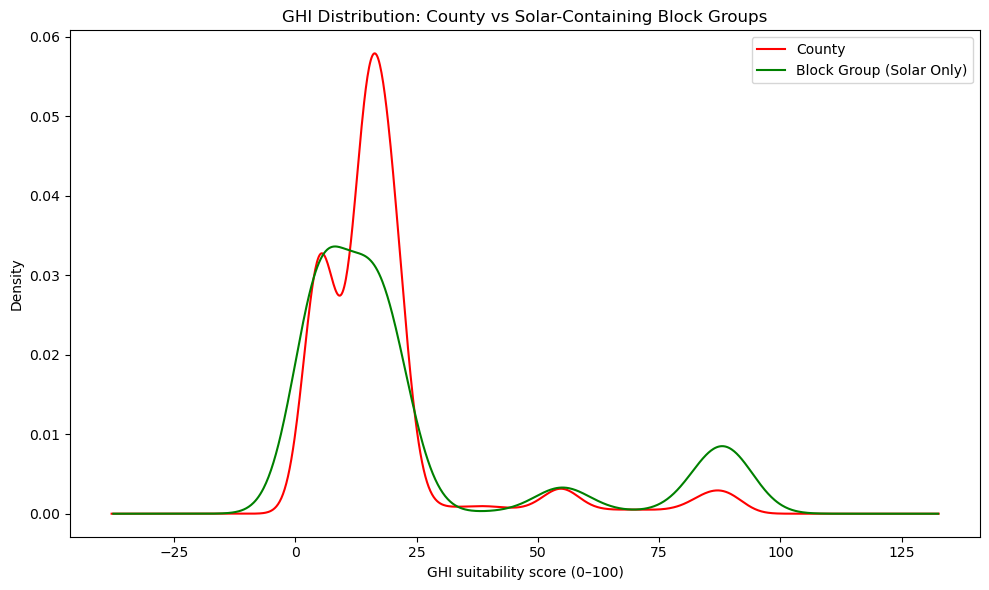

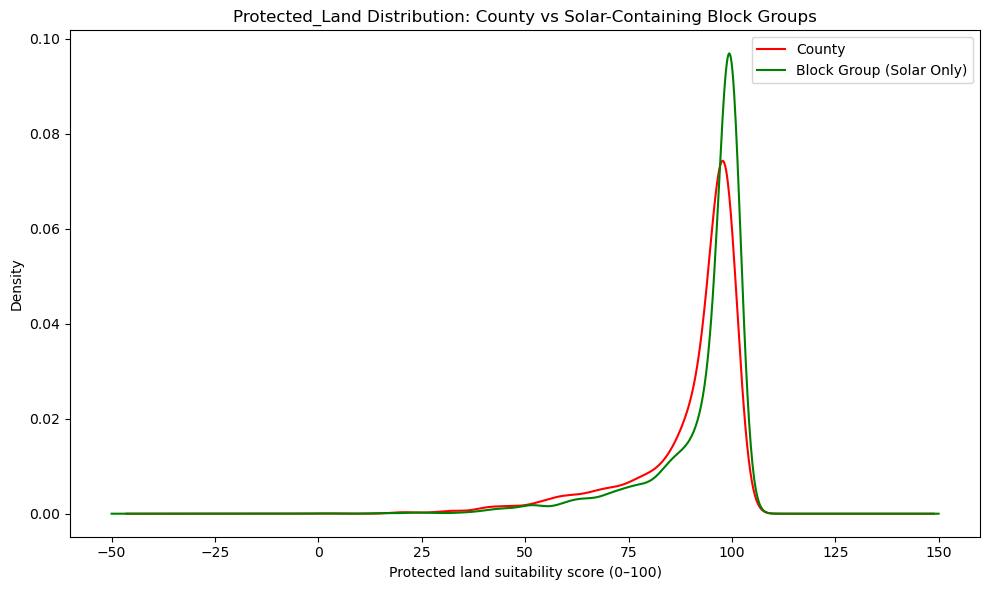

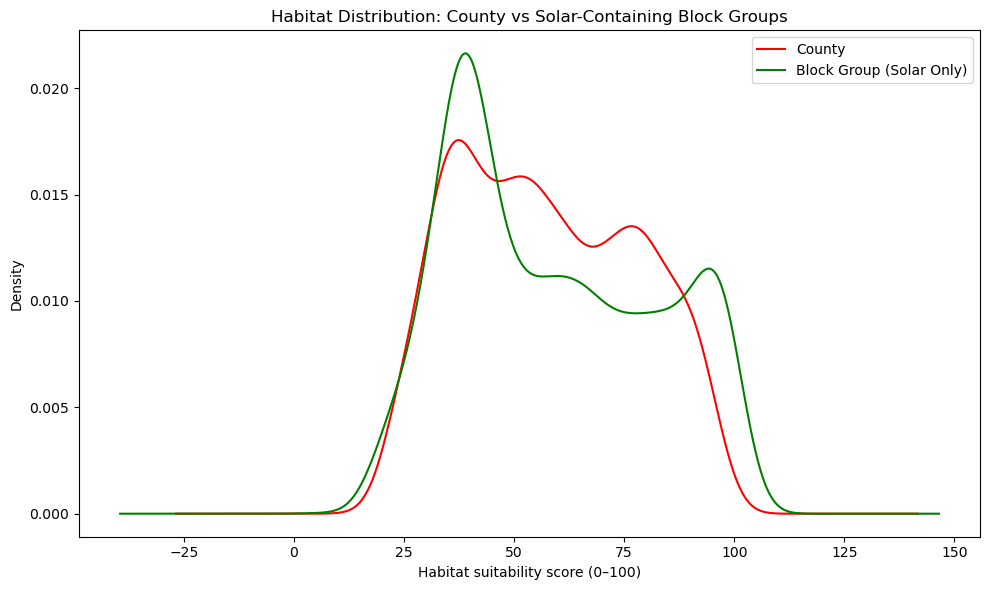

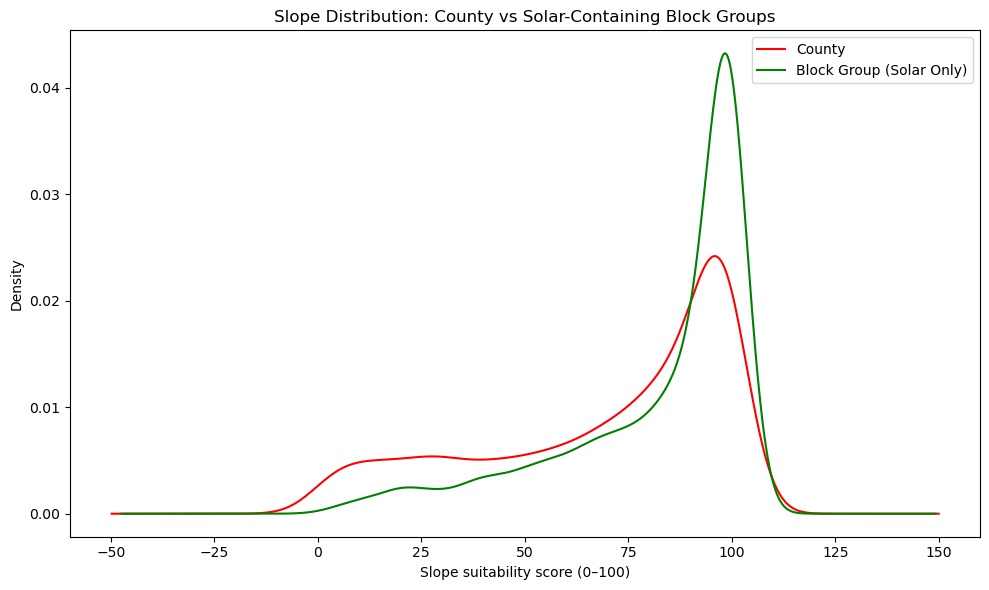

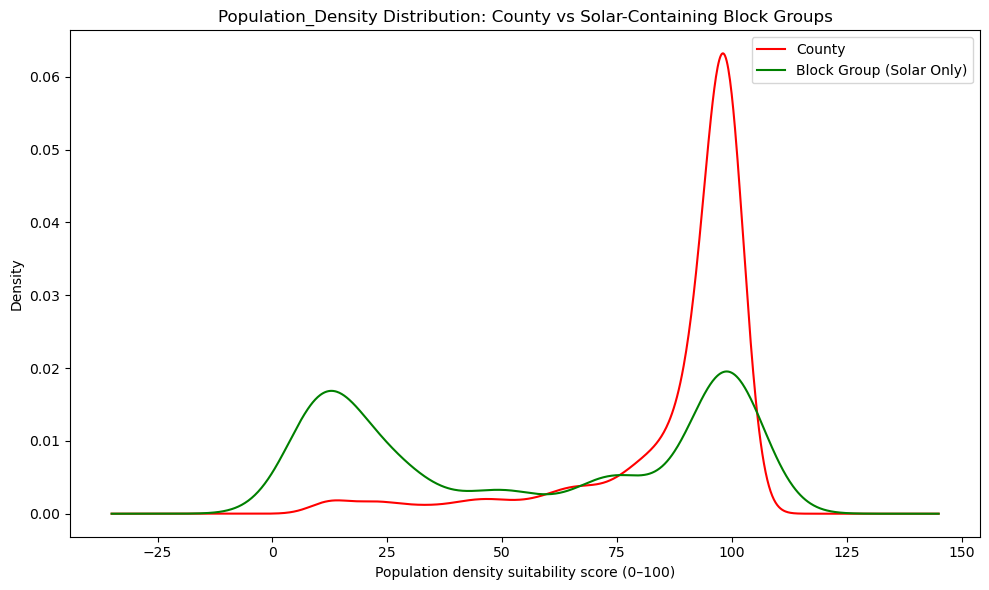

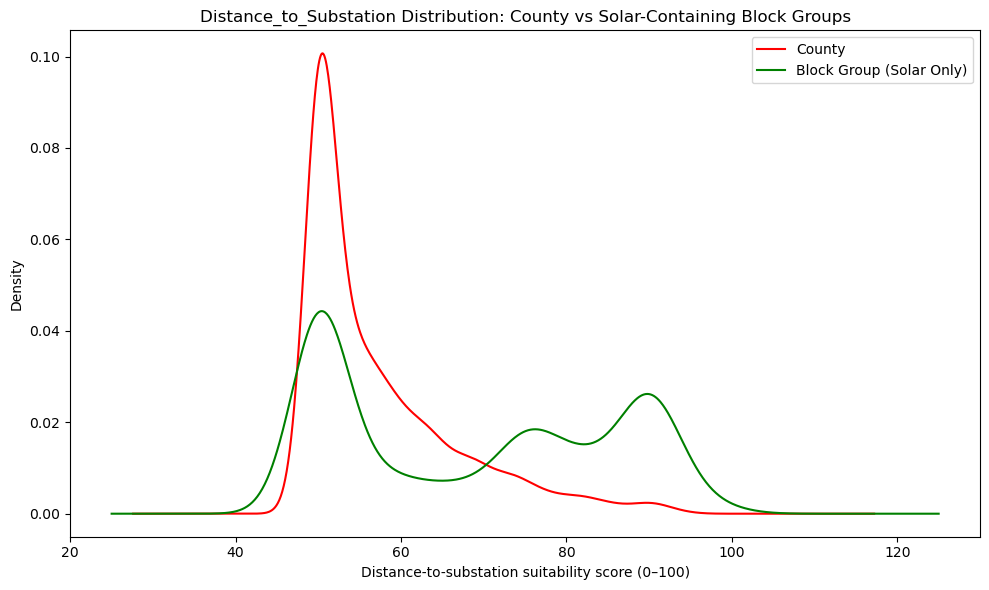

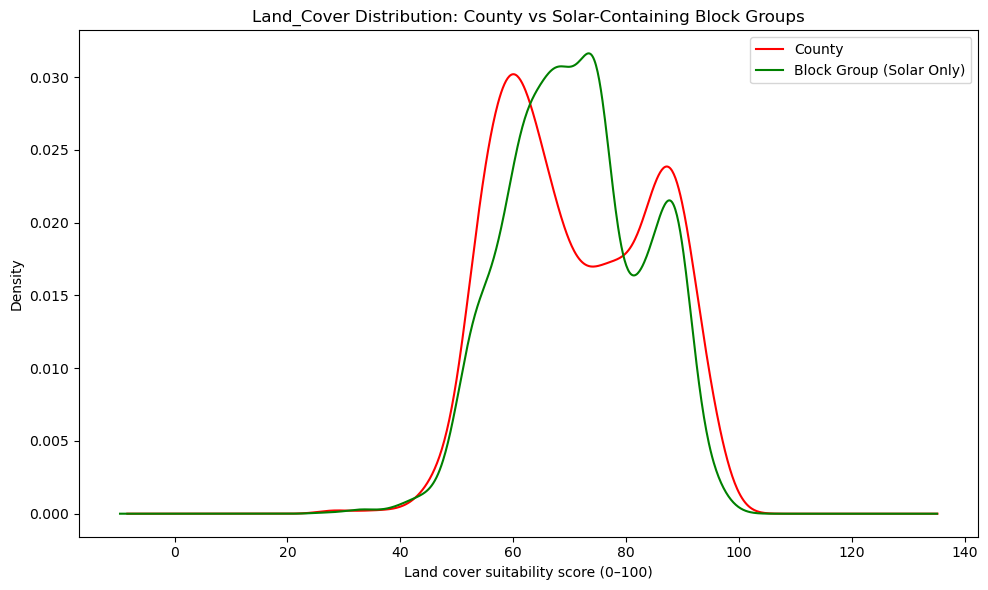

In [39]:
tech_factors = [
    "GHI", "Protected_Land", "Habitat", "Slope",
    "Population_Density", "Distance_to_Substation", "Land_Cover"
]

def safe_numeric(df, col):
    if df is None or col not in df.columns:
        return None
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if len(s) < 10 or s.nunique() < 2:
        return None
    return s

def tech_xlabel(col):
    mapping = {
        "GHI": "GHI suitability score (0–100)",
        "Protected_Land": "Protected land suitability score (0–100)",
        "Habitat": "Habitat suitability score (0–100)",
        "Slope": "Slope suitability score (0–100)",
        "Population_Density": "Population density suitability score (0–100)",
        "Distance_to_Substation": "Distance-to-substation suitability score (0–100)",
        "Land_Cover": "Land cover suitability score (0–100)",
    }
    return mapping.get(col, f"{col} suitability score")

for factor in tech_factors:
    c = safe_numeric(suitability_county, factor)
    b = safe_numeric(suitability_bg_solar, factor)

    fig, ax = plt.subplots(figsize=(10, 6))
    if c is not None:
        c.plot(kind="kde", ax=ax, color="red", label="County")
    if b is not None:
        b.plot(kind="kde", ax=ax, color="green", label="Block Group (Solar Only)")

    ax.set_title(f"{factor} Distribution: County vs Solar-Containing Block Groups")
    ax.set_xlabel(tech_xlabel(factor))
    ax.set_ylabel("Density")
    if ax.get_legend_handles_labels()[0]:
        ax.legend()
    plt.tight_layout()
    plt.show()

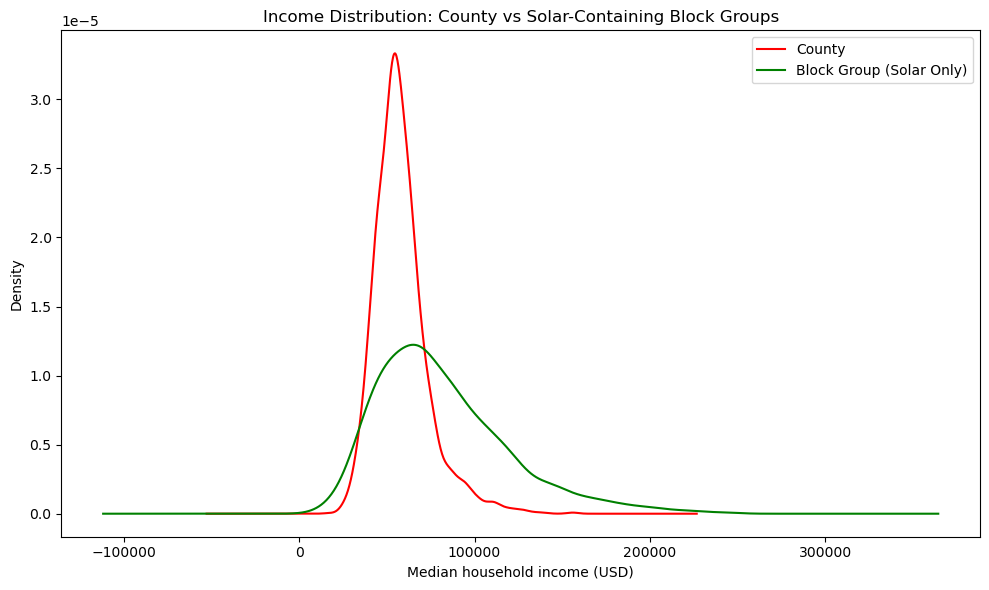

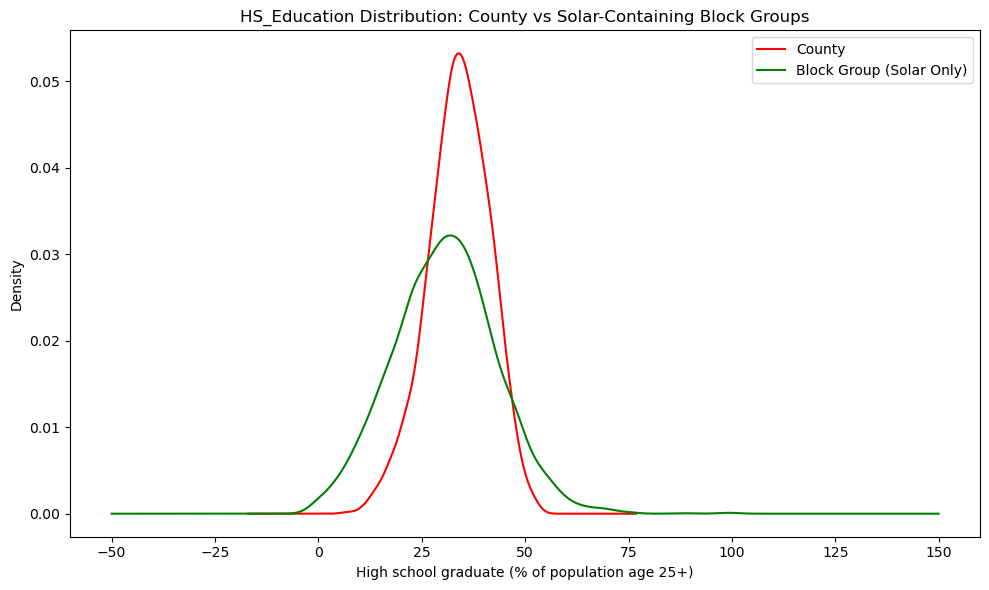

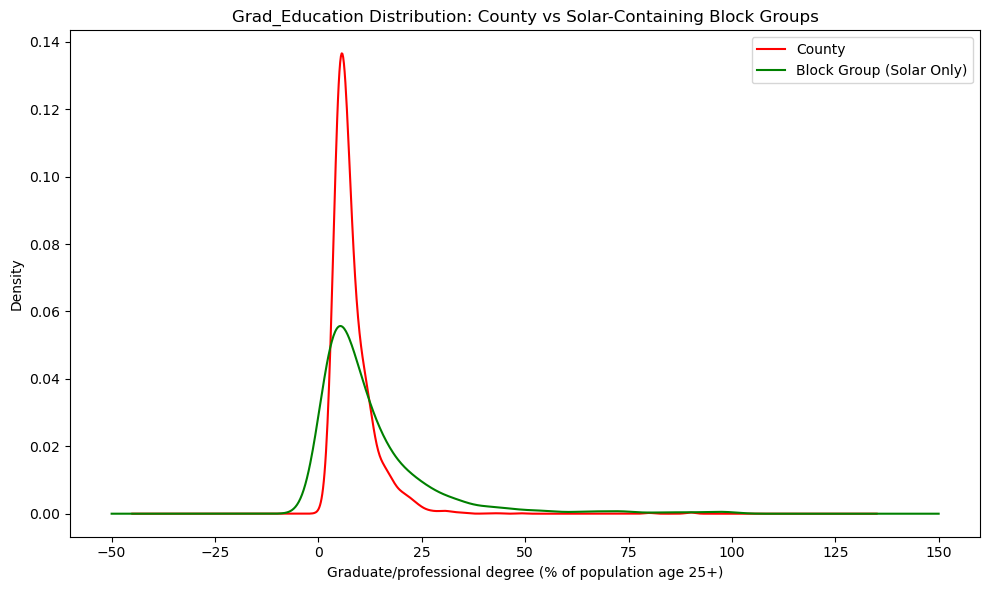

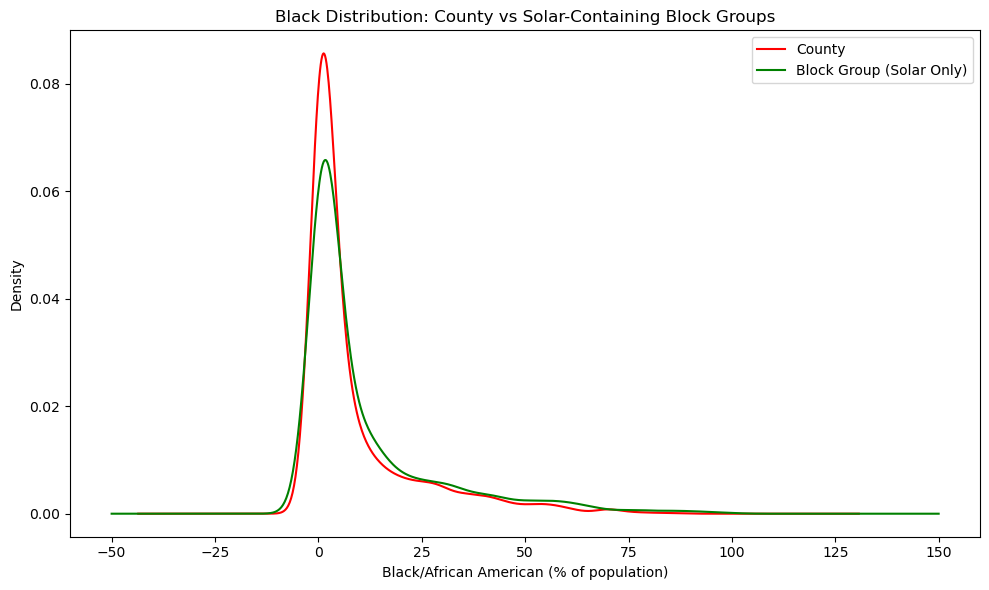

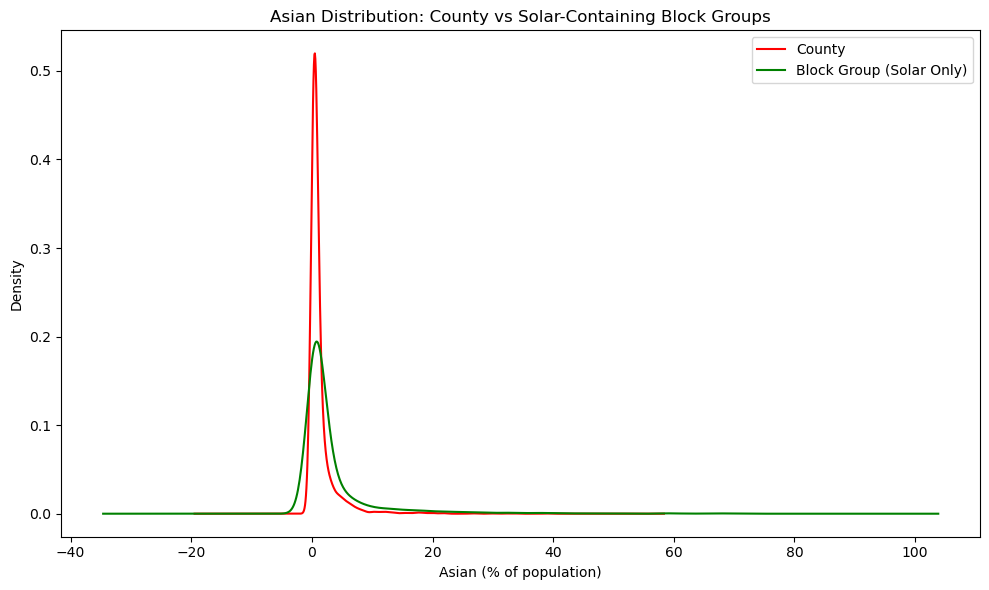

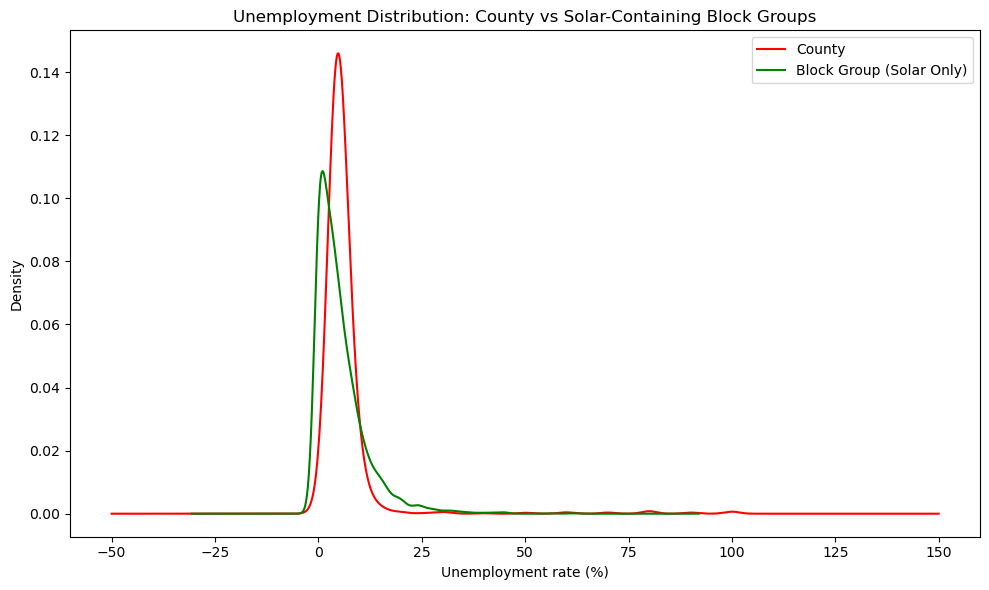

In [40]:
social_factors = ["Income", "HS_Education", "Grad_Education", "Black", "Asian", "Unemployment"]

social_xlabels = {
    "Income": "Median household income (USD)",
    "HS_Education": "High school graduate (% of population age 25+)",
    "Grad_Education": "Graduate/professional degree (% of population age 25+)",
    "Black": "Black/African American (% of population)",
    "Asian": "Asian (% of population)",
    "Unemployment": "Unemployment rate (%)",
}

social_titles = {
    "Income": "Income Distribution: County vs Solar-Containing Block Groups",
    "HS_Education": "HS_Education Distribution: County vs Solar-Containing Block Groups",
    "Grad_Education": "Grad_Education Distribution: County vs Solar-Containing Block Groups",
    "Black": "Black Distribution: County vs Solar-Containing Block Groups",
    "Asian": "Asian Distribution: County vs Solar-Containing Block Groups",
    "Unemployment": "Unemployment Distribution: County vs Solar-Containing Block Groups",
}

for factor in social_factors:
    c = safe_numeric(cty_social_small, factor)
    b = safe_numeric(bg_social_solar, factor)

    fig, ax = plt.subplots(figsize=(10, 6))
    if c is not None:
        c.plot(kind="kde", ax=ax, color="red", label="County")
    if b is not None:
        b.plot(kind="kde", ax=ax, color="green", label="Block Group (Solar Only)")

    ax.set_title(social_titles[factor])
    ax.set_xlabel(social_xlabels[factor])
    ax.set_ylabel("Density")
    if ax.get_legend_handles_labels()[0]:
        ax.legend()
    plt.tight_layout()
    plt.show()